In [1]:
import os
import torch 
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from model import weight_fun
device = torch.device("cpu")#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore")

In [2]:
# data = torch.load("SuEIRD_noise_discontinuity.pt").reshape(1, 60, 6)/1000
# first day 04/13
# list_csv[84] list_csv[91] list_csv[98]
direc = "/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/US_Reports/"
list_csv = sorted(os.listdir(direc))[2:]
us = []
for file in list_csv:
    sample = pd.read_csv(direc + file).set_index("Province_State")[["Confirmed", "Recovered", "Deaths"]].sort_values(by = "Confirmed", ascending = False)#"People_Hospitalized", 
    us.append(sample.drop(['Diamond Princess', 'Grand Princess']))
us = pd.concat(us, axis=1, join='inner') 
us_data = us.values.reshape(56,-1,3)
us_data = us_data#[:50]
us_data[us_data!=us_data] = 0
us_data[:,:,1] += us_data[:,:,2]
#us_data[:,:,0] -= us_data[:,:,1]
# standardization
population = pd.read_csv("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/population_states.csv", index_col=0)
scaler = population.loc[us.index].values.reshape(56, 1, 1)*1e6
scaler = scaler#[:50]
us_data = us_data/scaler
us_data = torch.from_numpy(us_data).float().to(device)
#beta = torch.load("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/us_beta.pt")

In [65]:
list_csv[91]

'07-13-2020.csv'

In [18]:
graph = torch.load("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/us_graph.pt").float()#[:50, :50]

In [20]:
class PiecewiseLinearModel(nn.Module):
    def __init__(self, n_breaks, num_regions):
        super(PiecewiseLinearModel, self).__init__()
        self.breaks = nn.Parameter(torch.rand((num_regions, 1, n_breaks)))
        self.linear = nn.Linear(n_breaks + 1, 1) 
#         self.linear.weight.data.fill_(0.001)
#         self.linear.bias.data.fill_(0.5)
    def forward(self, xx):
        if len(xx.shape) < 3:
            xx = xx.unsqueeze(-1)
        out = torch.cat([xx, F.relu(xx - self.breaks)],2)
        return self.linear(out).squeeze(-1)

In [25]:
class SuEIRD(nn.Module):
    def __init__(self, initial_I, initial_R, initial_D, num_regions, 
                 solver = "Euler", symmetric = False, low_rank = None, 
                 n_breaks = 0, graph = None, beta = None):
        super(SuEIRD, self).__init__()
        self.num_regions = num_regions
        self.init_I = initial_I
        self.init_R = initial_R
        self.init_D = initial_D        
        self.init_E = nn.Parameter(torch.tensor([0.5] * num_regions).float().to(device))
        self.init_S = nn.Parameter(torch.tensor([0.5] * num_regions).float().to(device)) 
        
#         self.A = np.zeros((num_regions, num_regions))
#         np.fill_diagonal(self.A, 1.0)
#         self.A = torch.from_numpy(self.A).float().to(device)
        if num_regions == 1:
            self.A = torch.ones(1, 1).to(device)
        else:
            if low_rank:
                if symmetric: 
                    self.B = nn.Parameter(torch.rand(num_regions, low_rank).to(device))
                    self.A = torch.mm(self.B, self.B.T)
                else:
                    self.B = nn.Parameter(torch.rand(num_regions, low_rank).to(device))
                    self.C = nn.Parameter(torch.rand(low_rank, num_regions).to(device))
                    self.A = torch.mm(self.B, self.C)
            else:
                self.A = nn.Parameter(torch.rand(num_regions, num_regions).to(device))
        
        self.graph = graph
        if beta is None:
            if n_breaks > 0:
                self.plm = PiecewiseLinearModel(n_breaks = n_breaks, num_regions = num_regions)
            else:
                self.beta = nn.Parameter(torch.rand(num_regions).to(device)/10)
        else:
            self.beta = beta
        self.n_breaks = n_breaks
        self.gamma = nn.Parameter(torch.rand(num_regions).to(device)/10)
        self.sigma = nn.Parameter(torch.rand(num_regions).to(device)/10)
        self.mu = nn.Parameter(torch.rand(num_regions).to(device)/10)
        self.step = torch.tensor(0.01).float().to(device)#)nn.Parameter(
        self.a = nn.Parameter(torch.rand(num_regions).to(device)/10)
        self.b = nn.Parameter(torch.rand(num_regions).to(device)/10)
        self.solver = solver
        self.init_U = (1-self.mu)*self.sigma*self.init_E
           #*self.graph)
        
    def Euler(self, num_steps):
        t = torch.linspace(1, num_steps, num_steps).repeat(self.num_regions, 1)
        if self.n_breaks > 0:
            beta = self.plm(t)
        else:
            beta = self.beta.repeat(1, num_steps)
        S_pred = [self.init_S]
        E_pred = [self.init_E]
        I_pred = [self.init_I]
        R_pred = [self.init_R]
        D_pred = [self.init_D]
        for n in range(num_steps - 1):
            if self.graph is None:
                S_pred.append(S_pred[n] - beta[:, n+1] * (torch.mm(self.A, ((I_pred[n] + E_pred[n]) * S_pred[n]).reshape(-1,1)).squeeze(1)) * self.step)
                E_pred.append(E_pred[n] + (beta[:, n+1] * S_pred[n] * (I_pred[n]+ E_pred[n]) - self.sigma * E_pred[n]) * self.step)
            else:
                S_pred.append(S_pred[n] - beta[:, n+1] * (torch.mm(self.graph*self.A, ((I_pred[n] + E_pred[n]) * S_pred[n]).reshape(-1,1)).squeeze(1)) * self.step)
                E_pred.append(E_pred[n] + (beta[:, n+1] * (torch.mm(self.graph*self.A, ((I_pred[n] + E_pred[n]) * S_pred[n]).reshape(-1,1)).squeeze(1)) - self.sigma * E_pred[n]) * self.step)
            #((I_pred[n] + E_pred[n]) * S_pred[n])
            #(torch.mm(self.A, ((I_pred[n] + E_pred[n]) * S_pred[n]).reshape(-1,1)).squeeze(1))
            
            I_pred.append(I_pred[n] + (self.mu * self.sigma * E_pred[n] - self.gamma*I_pred[n]) * self.step)
            R_pred.append(R_pred[n] + self.gamma * I_pred[n] * self.step)
            D_pred.append(D_pred[n] + self.a * torch.exp(- self.b * (n + 1) * self.step) * (R_pred[n+1] - R_pred[n]))
        y_pred = torch.cat([torch.stack(S_pred).transpose(0,1).unsqueeze(-1),
                           (torch.stack(E_pred)*(1-self.mu.unsqueeze(0))*self.sigma.unsqueeze(0)).transpose(0,1).unsqueeze(-1),
                            torch.stack(E_pred).transpose(0,1).unsqueeze(-1),
                            torch.stack(I_pred).transpose(0,1).unsqueeze(-1),
                            torch.stack(R_pred).transpose(0,1).unsqueeze(-1),
                            torch.stack(D_pred).transpose(0,1).unsqueeze(-1)], dim = -1)
        return y_pred
    
    def f_S(self, S_n, I_n, E_n, beta, n): 
        return -beta[:, n+1] * (torch.mm(self.A, ((I_n + E_n) * S_n).reshape(-1,1)).squeeze(1))
    ##  - self.beta * ((I_n + E_n) * S_n) 
    
    def f_E(self, S_n, I_n, E_n, beta, n): 
        return beta[:, n+1] * S_n * (I_n + E_n) - self.sigma * E_n
    
    def f_I(self, I_n, E_n):
        return self.mu * self.sigma * E_n - self.gamma*I_n
    
    def f_R(self, I_n):
        return self.gamma*I_n

    def RK4_update(self, f_n, k1, k2, k3, k4):
        return f_n + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4) * self.step
    
    def RK4(self, num_steps):
        
        t = torch.linspace(1, num_steps, num_steps).repeat(self.num_regions, 1)
        if self.n_breaks > 0:
            beta = self.plm(t)
        else:
            beta = self.beta.repeat(1, num_steps)
            
        S_pred = [self.init_S]
        E_pred = [self.init_E]
        I_pred = [self.init_I]
        R_pred = [self.init_R]
        D_pred = [self.init_D]
        for n in range(num_steps-1):
            # dt * f(t[n], y[n]) 
            k1_S = self.f_S(S_pred[n], I_pred[n], E_pred[n], beta, n)
            k1_E = self.f_E(S_pred[n], I_pred[n], E_pred[n], beta, n)
            k1_I = self.f_I(I_pred[n], E_pred[n])
            k1_R = self.f_R(I_pred[n])
            
            # dt * f(t[n] + dt/2, y[n] + k1/2)
            S_plus_k1_half = S_pred[n] + k1_S / 2 * self.step
            I_plus_k1_half = I_pred[n] + k1_I / 2 * self.step
            E_plus_k1_half = E_pred[n] + k1_E / 2 * self.step
            
            k2_S = self.f_S(S_plus_k1_half, I_plus_k1_half, E_plus_k1_half, beta, n)
            k2_E = self.f_E(S_plus_k1_half, I_plus_k1_half, E_plus_k1_half, beta, n)
            k2_I = self.f_I(I_plus_k1_half, E_plus_k1_half)
            k2_R = self.f_R(I_plus_k1_half)
            
            # dt * f(t[n] + dt/2, y[n] + k2/2)
            S_plus_k2_half = S_pred[n] + k2_S / 2 * self.step
            I_plus_k2_half = I_pred[n] + k2_I / 2 * self.step
            E_plus_k2_half = E_pred[n] + k2_E / 2 * self.step
            
            k3_S = self.f_S(S_plus_k2_half, I_plus_k2_half, E_plus_k2_half, beta, n)
            k3_E = self.f_E(S_plus_k2_half, I_plus_k2_half, E_plus_k2_half, beta, n)
            k3_I = self.f_I(I_plus_k2_half, E_plus_k2_half)
            k3_R = self.f_R(I_plus_k2_half)
            
            # dt * f(t[n] + dt, y[n] + k3) 
            S_plus_k3 = S_pred[n] + k3_S * self.step
            I_plus_k3 = I_pred[n] + k3_I * self.step
            E_plus_k3 = E_pred[n] + k3_E * self.step
            
            k4_S = self.f_S(S_plus_k3, I_plus_k3, E_plus_k3, beta, n)           
            k4_E = self.f_E(S_plus_k3, I_plus_k3, E_plus_k3, beta, n)
            k4_I = self.f_I(I_plus_k3, E_plus_k3) 
            k4_R = self.f_R(I_plus_k3)

            S_pred.append(self.RK4_update(S_pred[n], k1_S, k2_S, k3_S, k4_S))
            E_pred.append(self.RK4_update(E_pred[n], k1_E, k2_E, k3_E, k4_E))
            I_pred.append(self.RK4_update(I_pred[n], k1_I, k2_I, k3_I, k4_I))
            R_pred.append(self.RK4_update(R_pred[n], k1_R, k2_R, k3_R, k4_R))
            
        for n in range(num_steps - 1):
            D_pred.append(D_pred[n] + (self.a * (n * self.step) + self.b) * (R_pred[n+1] - R_pred[n]))
            #self.a * torch.exp(- self.b * (n + 1) * self.step) * 

        y_pred = torch.cat([torch.stack(S_pred).transpose(0,1).unsqueeze(-1),
                            (torch.stack(E_pred)*(1-self.mu.unsqueeze(0))*self.sigma.unsqueeze(0)).transpose(0,1).unsqueeze(-1),
                            torch.stack(E_pred).transpose(0,1).unsqueeze(-1),
                            torch.stack(I_pred).transpose(0,1).unsqueeze(-1),
                            torch.stack(R_pred).transpose(0,1).unsqueeze(-1),
                            torch.stack(D_pred).transpose(0,1).unsqueeze(-1)], dim = -1)
        return y_pred
    
        
    def forward(self, num_steps):
        if self.solver == "Euler":
            return self.Euler(num_steps)[:,:,-3:]
        elif self.solver == "RK4":
            return self.RK4(num_steps)[:,:,-3:]
        else:
            print("Error")        

In [22]:
list_csv[84]

'07-06-2020.csv'

In [23]:
#84] list_csv[91] list_csv[98]

In [28]:
#for test_idx in list(range(77, 14, -7)):#= 98# 988491
test_idx = 98
input_steps =  7
data = us_data[:, test_idx-input_steps:test_idx+7]
y_exact = data[:,:input_steps]

model = SuEIRD(initial_I = data[:,0,0], initial_R = data[:,0,1], initial_D = data[:,0,2],
               num_regions = 56, solver = "Euler", n_breaks = 1, graph = graph).to(device)

optimizer = torch.optim.Adam(model.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1000, gamma=0.9)
num_epochs = 30000
loss_fun = torch.nn.MSELoss()
tqdm_epochs = range(num_epochs)
min_loss = 1
for e in tqdm_epochs:
    scheduler.step()
    #positive_constraint = loss_fun(F.relu(-model.beta), torch.tensor(0.0).float().to(device))

    #diagonal_constraint = loss_fun(torch.diagonal(model.A, 0),torch.tensor(1.0).float().to(device))

    #initial_constraint = loss_fun(model.init_S + model.init_E + model.init_I + model.init_R + model.init_U, torch.tensor(1.0).float().to(device))

    y_approx = model(input_steps)

    #loss = loss_fun(y_approx[:,:,-3:], y_exact[:,:input_steps,-3:])
    loss_weight = weight_fun(input_steps, function = "sqrt", feat_weight = True)
    loss = torch.mean(loss_weight*loss_fun(y_approx[:,:,-3:], y_exact[:,:input_steps,-3:])) 
    #loss += initial_constraint #+ positive_constraint#+ diagonal_constraint  # #

    if loss.item() < min_loss:
        best_model = model
        min_loss = loss.item()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)#retain_graph=True
    optimizer.step()

    if e%1000 == 0:
        print("Epoch:", e, ' Loss:', min_loss)
        y_approx2 = best_model(data.shape[1]).data.numpy()
        y_exact2 = data.data.numpy()
        #torch.mean(torch.abs(y_approx - y_exact)[:,-7:]).data, torch.mean(torch.abs(y_approx - y_exact)[:,30:]).data
        for i in range(3):
            print(np.mean(np.abs(y_approx2*scaler - y_exact2*scaler)[:,-7:, i]))

y_approx2 = best_model(data.shape[1]).data.numpy()
y_exact2 = data.data.numpy()
print(list_csv[test_idx][:10])
#torch.mean(torch.abs(y_approx - y_exact)[:,-7:]).data, torch.mean(torch.abs(y_approx - y_exact)[:,30:]).data
for i in range(3):
    print(np.mean(np.abs(y_approx2*scaler - y_exact2*scaler)[:,-7:, i]))

Epoch: 0  Loss: 1.3771828832886968e-07
11813.488709080222
3609.2704031942303
140.50376643784654
Epoch: 1000  Loss: 7.482558572746711e-09
1967.2088363295268
2930.597748585609
117.40054174800639
Epoch: 2000  Loss: 5.1979793802559016e-09
2036.5425753055868
2426.387179051516
110.21327287819683
Epoch: 3000  Loss: 4.3848293884707346e-09
2086.0890935924613
2113.736017472914
120.01552515782842
Epoch: 4000  Loss: 3.942047133165261e-09
2116.0239392463523
1911.6518132537606
125.23738811506192
Epoch: 5000  Loss: 3.649603952382563e-09
2127.354314934944
1763.3789538251947
126.49618369069229
Epoch: 6000  Loss: 3.4386844482980905e-09
2123.807631875838
1647.9327860792864
125.35957486936393
Epoch: 7000  Loss: 3.2793854298773795e-09
2110.149718194174
1553.1779027191728
122.87491981795024
Epoch: 8000  Loss: 3.155428363044166e-09
2091.0666703642223
1474.8608740763398
119.84588675281267
Epoch: 9000  Loss: 3.056811026524997e-09
2070.1080093117357
1409.5996954855018
116.79614545408936
Epoch: 10000  Loss: 2.97

KeyboardInterrupt: 

In [30]:
np.mean([1257,
2133,
136,
1746,
1984,
136,
1071,
1184
142&])

832.5

In [16]:
y_approx2 = best_model(data.shape[1]).data.numpy()
y_exact2 = data.data.numpy()
print(list_csv[test_idx][:10])
#torch.mean(torch.abs(y_approx - y_exact)[:,-7:]).data, torch.mean(torch.abs(y_approx - y_exact)[:,30:]).data
for i in range(3):
    print(np.mean(np.abs(y_approx2*scaler - y_exact2*scaler)[:,-7:, i]))

07-20-2020
1606.8070171401723
827.8162548695361
91.92795943663458


In [17]:
torch.save({"model": best_model,
            "preds": y_approx2*scaler,
            "trues": y_exact*scaler},
            "SuEIRD_0720.pt")

In [18]:
y_approx = best_model(data.shape[1]).data.numpy()
y_exact = data.data.numpy()
print(np.mean(np.abs(y_approx - y_exact)[:,-30:]))
torch.save({"MAE": np.mean(np.abs(y_approx - y_exact)[:,-30:]), 
            "model": best_model,
            "preds": y_approx,
            "trues": y_exact},
            "SuEIRD_0.pt")

0.17744002


In [41]:
name = "SuEIRD_2"
results = torch.load(name + ".pt")
y_approx = results["preds"]
y_true = results["trues"]

In [42]:
sue30 = np.mean(np.abs((y_approx - y_true)[:,:30,:3]))
sue60 = np.mean(np.abs((y_approx - y_true)[:,-30:,:3]))
ird30 = np.mean(np.abs((y_approx - y_true)[:,:30,-3:]))
ird60 = np.mean(np.abs((y_approx - y_true)[:,-30:,-3:]))
sue30, sue60, ird30, ird60

(0.044130843, 0.031220354, 0.011758171, 0.114629)

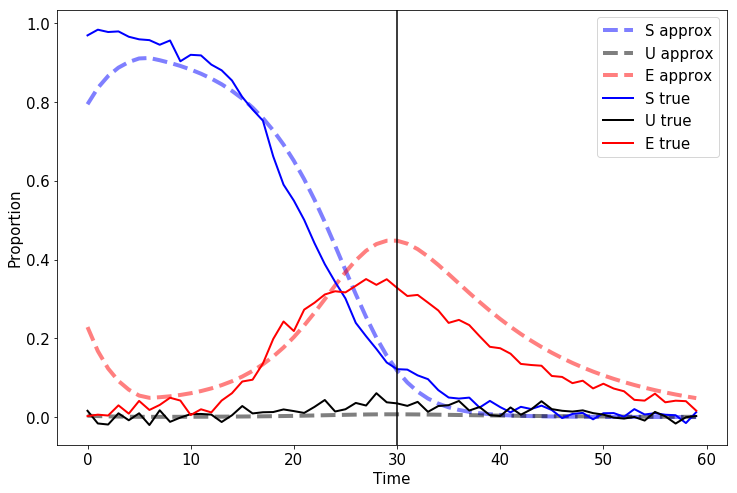

In [43]:
idx = 0
x = np.linspace(0, y_exact.shape[1]-1, y_exact.shape[1])
fig=plt.figure(figsize=(12, 8))

plt.plot(x, y_approx[idx,:,0], 'b', alpha=0.5, lw=4, linestyle = "--", label='S approx')
plt.plot(x, y_approx[idx,:,1], 'black', alpha=0.5, lw=4, linestyle = "--", label='U approx')
plt.plot(x, y_approx[idx,:,2], 'red', alpha=0.5, lw=4, linestyle = "--", label='E approx')

plt.plot(x, y_exact[idx,:,0], 'b', alpha=1, lw=2,  label='S true')
plt.plot(x, y_exact[idx,:,1], 'black', alpha=1, lw=2,  label='U true')
plt.plot(x, y_exact[idx,:,2], 'red', alpha=1, lw=2,  label='E true')

plt.axvline(30, color = "black")
plt.xlabel('Time', size = 15)
plt.ylabel('Proportion', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

#plt.grid(b=True, c='w', lw=2, ls='-')
plt.legend(fontsize = 15, loc = 0)

#plt.title(name, fontsize = 20)
plt.savefig(name + "_sue.png", dpi = 400 , bbox_inches = "tight")   #"SuEIRD_Corr_" + us.index[idx] + ".png" 
plt.show()

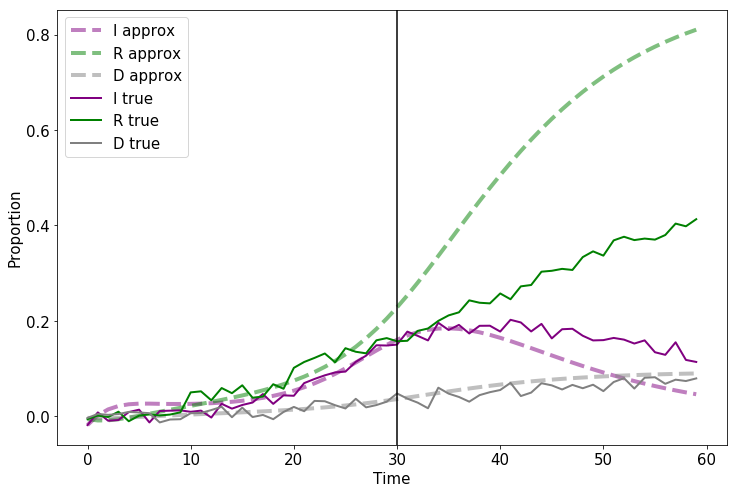

In [44]:
idx = 0
x = np.linspace(0, y_exact.shape[1]-1, y_exact.shape[1])
fig=plt.figure(figsize=(12, 8))

plt.plot(x, y_approx[idx,:,3], 'purple', alpha=0.5, lw=4, linestyle = "--", label='I approx')
plt.plot(x, y_approx[idx,:,4], 'green', alpha=0.5, lw=4, linestyle = "--", label='R approx')
plt.plot(x, y_approx[idx,:,5], 'grey', alpha=0.5, lw=4, linestyle = "--", label='D approx')

plt.plot(x, y_exact[idx,:,3], 'purple', alpha=1, lw=2,  label='I true')
plt.plot(x, y_exact[idx,:,4], 'green', alpha=1, lw=2,  label='R true')
plt.plot(x, y_exact[idx,:,5], 'grey', alpha=1, lw=2,  label='D true')

plt.axvline(30, color = "black")
plt.xlabel('Time', size = 15)
plt.ylabel('Proportion', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.grid(b=True, c='w', lw=2, ls='-')
plt.legend(fontsize = 15, loc = 0)

#plt.title(name, fontsize = 20)
plt.savefig(name + "_ird.png", dpi = 400 , bbox_inches = "tight")   #"SuEIRD_Corr_" + us.index[idx] + ".png" 
plt.show()

In [ ]:
# ###### y_approx2 = best_model(data.shape[1]).data.numpy()
# y_exact2 = data.data.numpy()
# print(list_csv[test_idx][:10])
# #torch.mean(torch.abs(y_approx - y_exact)[:,-7:]).data, torch.mean(torch.abs(y_approx - y_exact)[:,30:]).data
# for i in range(3):
#     print(np.mean(np.abs(y_approx2*scaler - y_exact2*scaler)[:,-7:, i]))
# torch.save({"model": best_model, 
#             "preds": y_approx,
#             "trues": y_exact},
#             "AdjMask_SuEIRD_0720.pt")
# name = "Total_SuEIRD-Piecewise-RK4"
# torch.save(best_model, "SuEIRD_Piecewise/" +name + ".pth")

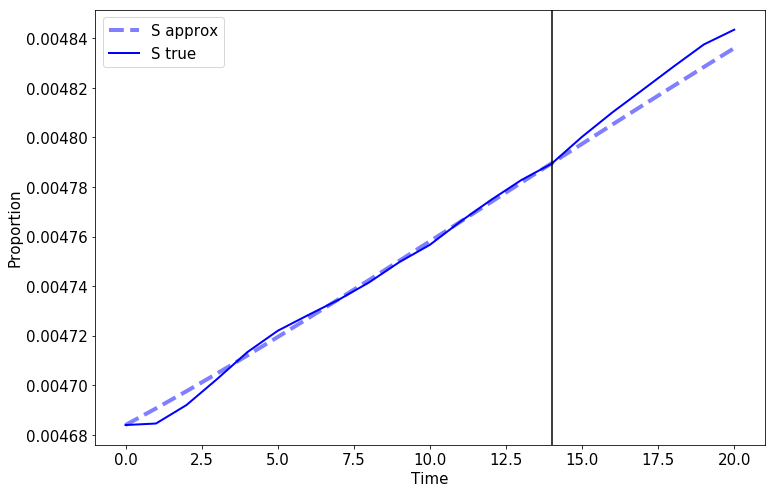

In [124]:
idx = 0
x = np.linspace(0, y_exact.shape[1]-1, y_exact.shape[1])
fig=plt.figure(figsize=(12, 8))

plt.plot(x, y_approx[idx,:,0], 'b', alpha=0.5, lw=4, linestyle = "--", label='S approx')
#plt.plot(x, y_approx[idx,:,1], 'black', alpha=0.5, lw=4, linestyle = "--", label='U approx')
#plt.plot(x, y_approx[idx,:,2], 'red', alpha=0.5, lw=4, linestyle = "--", label='E approx')

plt.plot(x, y_exact[idx,:,0], 'b', alpha=1, lw=2,  label='S true')
#plt.plot(x, y_exact[idx,:,1], 'black', alpha=1, lw=2,  label='U true')
#plt.plot(x, y_exact[idx,:,2], 'red', alpha=1, lw=2,  label='E true')
plt.axvline(14, color = "black")
plt.xlabel('Time', size = 15)
plt.ylabel('Proportion', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.grid(b=True, c='w', lw=2, ls='-')
plt.legend(fontsize = 15, loc = 0)

#plt.title(name, fontsize = 20)
#plt.savefig("SuEIRD_Piecewise/" + name + "_sue.png", dpi = 400 , bbox_inches = "tight")   #"SuEIRD_Corr_" + us.index[idx] + ".png" 
plt.show()

In [59]:
best_model = torch.load("SuEIRD_Piecewise/Total_SuEIRD-Piecewise-RK4.pth")
y_approx = best_model(data.shape[1]).data.numpy()
y_exact = data.data.numpy()

In [60]:
name = "SuEIRD-Piecewise-Euler-ALL"

In [14]:
#torch.load("SuEIRD_Piecewise/Total_SuEIRD-Linear-Euler.pth").beta
true_beta = [0.5]*10 + [0.9]*10 + [0.7]*10
linear_euler = [0.8461]*30
linear_rk4 = [0.7941]*30
piecewise_euler = torch.load("SuEIRD_Piecewise/Total_SuEIRD-Piecewise-Euler.pth").plm(torch.linspace(1, 30, 30).repeat(1,1))[0].cpu().data.numpy()
piecewise_rk4 = torch.load("SuEIRD_Piecewise/Total_SuEIRD-Piecewise-RK4.pth").plm(torch.linspace(1, 30, 30).repeat(1,1))[0].cpu().data.numpy()

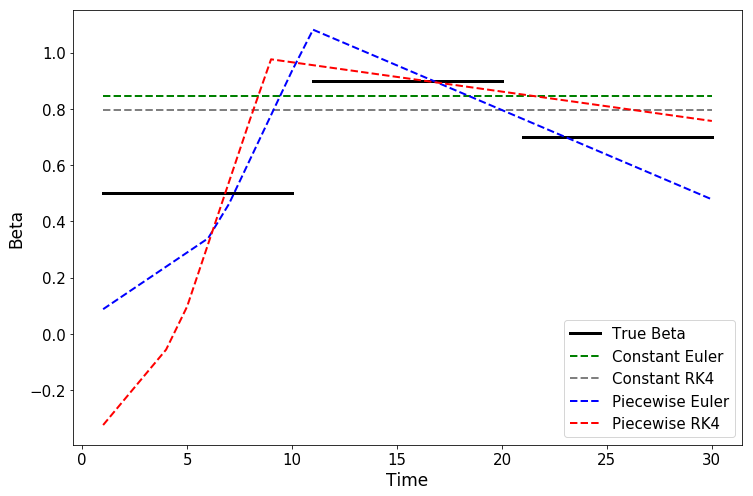

In [15]:
idx = 0
x = np.linspace(1, 30, 30)
fig=plt.figure(figsize=(12, 8))
plt.plot(x[:10], true_beta[:10], 'black', alpha=1, lw=3, label='True Beta')
plt.plot(x[10:20], true_beta[10:20], 'black', alpha=1, lw=3)
plt.plot(x[20:30], true_beta[20:30], 'black', alpha=1, lw=3)

plt.plot(x, linear_euler, 'green', alpha=1, lw=2, linestyle = "--", label='Constant Euler')
plt.plot(x, linear_rk4, 'grey', alpha=1, lw=2, linestyle = "--", label='Constant RK4')
plt.plot(x, piecewise_euler, 'blue', alpha=1, lw=2, linestyle = "--", label='Piecewise Euler')
plt.plot(x, piecewise_rk4, 'red', alpha=1, lw=2, linestyle = "--", label='Piecewise RK4')
plt.xlabel('Time', size = 17)
plt.ylabel('Beta', size = 17)
plt.xticks(size = 15)
plt.yticks(size = 15)

plt.grid(b=True, c='w', lw=2, ls='-')
plt.legend(fontsize = 15, loc = 0)

#plt.title(name, fontsize = 20)
plt.savefig("SuEIRD_Piecewise/beta_total.png", dpi = 400 , bbox_inches = "tight")   
plt.show()

In [4]:
#sign = lambda u: u > torch.zeros(1) 
# self.breakpoints = nn.Parameter(torch.rand(num_regions, 2).to(device))
# self.a0 = nn.Parameter(torch.rand(num_regions, 1).to(device)/10)
# self.a1 = nn.Parameter(torch.rand(num_regions, 1).to(device)/10)
# self.a2 = nn.Parameter(torch.rand(num_regions, 1).to(device)/10)
#         self.beta = self.a0*sign(t) + \
#                     self.a1*sign(t - breakpoints[:,0:1].repeat(1,num_steps)) + \
#                     self.a2*sign(t - (breakpoints[:,1:2]+breakpoints[:,0:1]).repeat(1,num_steps))
#print(model.init_E, model.init_S)
#         print(model.beta.detach().numpy() - 0.8, 
#           model.gamma.detach().numpy() - 0.1, 
#           model.sigma.detach().numpy() - 0.2,
#           model.mu.detach().numpy() - 0.5)